In [1]:
import tensorflow as tf
import keras
from keras.layers import Input, Dense, Flatten, Conv1D
from keras.models import Model
from keras.regularizers import l1
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import os
import h5py
import pandas as pd
from constraints import *

Using TensorFlow backend.


In [2]:
#h5f = h5py.File('KERAS_conv1d_weights.h5', 'r')
Inputs = Input(shape=(7, 1,))
x = Conv1D(filters=8, kernel_size=4, strides=1, padding='same', 
           kernel_initializer='VarianceScaling', use_bias=True, name='conv1_relu', 
           activation = 'relu')(Inputs)
#, kernel_constraint = zero_some_weights(binary_tensor=h5f['conv1_relu'][()].tolist())
x = Conv1D(filters=4, kernel_size=4, strides=2, padding='same', 
           kernel_initializer='VarianceScaling', use_bias=True, name='conv2_relu',
           activation = 'relu')(x)
#, kernel_constraint = zero_some_weights(binary_tensor=h5f['conv2_relu'][()].tolist())
x = Conv1D(filters=2, kernel_size=4, strides=3, padding='same', 
           kernel_initializer='VarianceScaling', use_bias=True, name='conv3_relu',
           activation = 'relu')(x)
#, kernel_constraint = zero_some_weights(binary_tensor=h5f['conv3_relu'][()].tolist())
x = Flatten()(x)
predictions = Dense(5, activation='softmax', kernel_initializer='VarianceScaling', bias_initializer='VarianceScaling', 
                    kernel_regularizer='L1L2', name='output_softmax')(x)
#, kernel_constraint = zero_some_weights(binary_tensor=h5f['output_softmax'][()].tolist())
model = Model(inputs=Inputs, outputs=predictions)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 7, 1)]            0         
_________________________________________________________________
conv1_relu (Conv1D)          (None, 7, 8)              40        
_________________________________________________________________
conv2_relu (Conv1D)          (None, 4, 4)              132       
_________________________________________________________________
conv3_relu (Conv1D)          (None, 2, 2)              34        
_________________________________________________________________
flatten (Flatten)            (None, 4)                 0         
_________________________________________________________________
output_softmax (Dense)       (None, 5)                 25        
Total params: 231
Trainable params: 231
Non-trainable params: 0
_______________________________________________________________

In [3]:
f = h5py.File('processed-pythia82-lhc13-all-pt1-50k-r1_h022_e0175_t220_nonu_withPars_truth.z', 'r')
treeArray = f['t_allpar_new'][()]

features = ['j1_ptrel', 'j1_etarot', 'j1_phirot', 'j1_erel', 'j1_deltaR', 'j1_costhetarel', 'j1_pdgid']
labels = ['j_g', 'j_q', 'j_w', 'j_z', 'j_t']

features_labels_df = pd.DataFrame(treeArray,columns=list(set(features+labels)))
features_labels_df = features_labels_df.drop_duplicates()

features_val = features_labels_df[features].values #Convert to numpy array
labels_val = features_labels_df[labels].values

In [4]:
X_train, X_test, y_train, y_test = train_test_split(features_val, labels_val, test_size=0.2, random_state=42)

In [5]:
adam = Adam(lr=0.0001)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

In [6]:
history = model.fit(X_train, y_train, batch_size = 1024, epochs = 50, 
                    validation_split = 0.25, shuffle = True, callbacks = None,
                    use_multiprocessing=True, workers=4)

Epoch 1/50
3000/3000 [==============================] - 10s 3ms/step - loss: 2.2213 - accuracy: 0.2823 - val_loss: 1.5257 - val_accuracy: 0.2903
Epoch 2/50
3000/3000 [==============================] - 10s 3ms/step - loss: 1.4430 - accuracy: 0.2984 - val_loss: 1.4290 - val_accuracy: 0.3040
Epoch 3/50
3000/3000 [==============================] - 10s 3ms/step - loss: 1.4240 - accuracy: 0.3157 - val_loss: 1.4263 - val_accuracy: 0.3184
Epoch 4/50
3000/3000 [==============================] - 10s 3ms/step - loss: 1.4232 - accuracy: 0.3181 - val_loss: 1.4254 - val_accuracy: 0.3184
Epoch 5/50
3000/3000 [==============================] - 10s 3ms/step - loss: 1.4227 - accuracy: 0.3194 - val_loss: 1.4246 - val_accuracy: 0.3188
Epoch 6/50
3000/3000 [==============================] - 10s 3ms/step - loss: 0.9694 - accuracy: 0.3176 - val_loss: 0.4908 - val_accuracy: 0.3156
Epoch 7/50
3000/3000 [==============================] - 10s 3ms/step - loss: 0.4889 - accuracy: 0.3180 - val_loss: 0.4900 - val_ac

In [7]:
model.save('Conv1D') #Saves to local directory; model file 'two-layer' with no extension

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: Conv1D\assets


In [8]:
loaded_model = keras.models.load_model('Conv1D') #Loads from local directory

In [9]:
loaded_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 7, 1)]            0         
_________________________________________________________________
conv1_relu (Conv1D)          (None, 7, 8)              40        
_________________________________________________________________
conv2_relu (Conv1D)          (None, 4, 4)              132       
_________________________________________________________________
conv3_relu (Conv1D)          (None, 2, 2)              34        
_________________________________________________________________
flatten (Flatten)            (None, 4)                 0         
_________________________________________________________________
output_softmax (Dense)       (None, 5)                 25        
Total params: 231
Trainable params: 231
Non-trainable params: 0
_______________________________________________________________

In [10]:
import matplotlib.pyplot as plt

In [11]:
def learningCurve(history):
    plt.figure(figsize=(10,8))
    plt.plot(history.history['loss'], linewidth=1)
    plt.plot(history.history['val_loss'], linewidth=1)
    plt.title('Model Loss over Epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['training sample loss','validation sample loss'])
    #plt.savefig('Learning_curve.pdf')
    plt.show()
    plt.close()

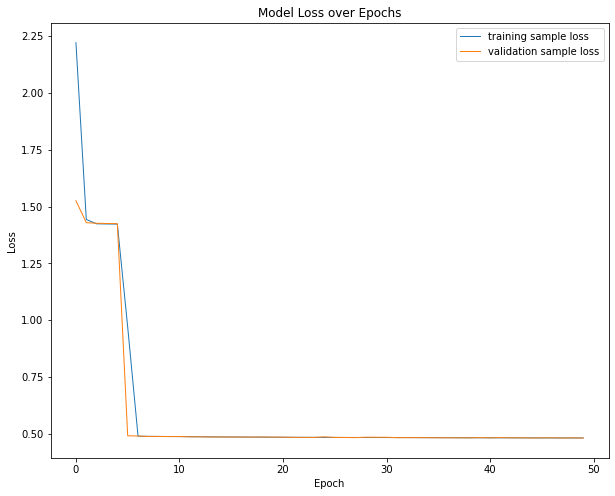

In [12]:
learningCurve(history)

In [14]:
def makeRoc(features_val, labels_val, labels, model, outputDir='', outputSuffix=''):
    from sklearn.metrics import roc_curve, auc
    labels_pred = model.predict(features_val)
    df = pd.DataFrame()
    fpr = {}
    tpr = {}
    auc1 = {}
    plt.figure(figsize=(10,8))       
    for i, label in enumerate(labels):
        df[label] = labels_val[:,i]
        df[label + '_pred'] = labels_pred[:,i]
        fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])
        auc1[label] = auc(fpr[label], tpr[label])
        plt.plot(fpr[label],tpr[label],label='%s tagger, AUC = %.1f%%'%(label.replace('j_',''),auc1[label]*100.))
    plt.plot([0, 1], [0, 1], lw=1, color='black', linestyle='--')
    #plt.semilogy()
    plt.xlabel("Background Efficiency")
    plt.ylabel("Signal Efficiency")
    plt.xlim([-0.05, 1.05])
    plt.ylim(0.001,1.05)
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.figtext(0.25, 0.90,'LSTM ROC Curve',fontweight='bold', wrap=True, horizontalalignment='right', fontsize=14)
    #plt.figtext(0.35, 0.90,'preliminary', style='italic', wrap=True, horizontalalignment='center', fontsize=14) 
    #plt.savefig('%sROC_%s.pdf'%(outputDir, outputSuffix))
    return labels_pred

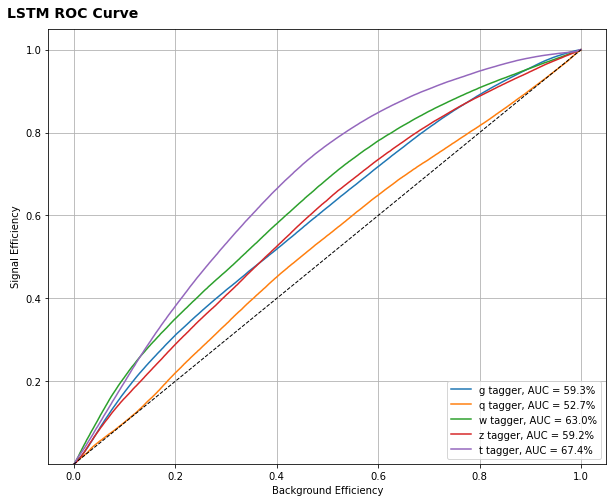

In [15]:
y_pred = makeRoc(X_test, y_test, labels, model, outputSuffix='Con1D')